In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

Numerical method: Forward Euler (Explicit)

# Heston PDE

$$
\frac{\partial U}{\partial t}(S,v,t) = \frac 1 2 vS^2\frac{\partial^2 U}{\partial S^2 } + \rho\sigma vS \frac{\partial^2 U}{\partial S\partial v} + \frac 1 2 \sigma^2v \frac{\partial^2U}{\partial v^2} + rS\frac{\partial U}{\partial S} + \kappa(\theta - v)\frac{\partial U}{\partial v}-rU
$$
Initial condition:
$$
    U(S, v, 0) = max(0,S - K)
$$
Boundary condition:
$$
\begin{align}
    U(0,v,t) &=& 0\\
    \lim_{S\to\infty} \frac{\partial U}{\partial s}(S,v,t) &=& 0\\
    rS\frac{\partial U}{\partial S}(S,0,t) + \kappa\theta\frac{\partial U}{\partial v}(S,0,t) - rU(S,0,t)+\frac{\partial U}{\partial t}(S,0,t) &=& 0\\
    \lim_{v\to\infty}U(S,v,t) &=& S
\end{align}
$$

# Discretization

## PDE

* For the first and second derivatives $\rightarrow$ Use the central finite difference approximations
* For the cross derivatives $\rightarrow$ Use the second order approximation in both $S$ and $v$

$$
\begin{align}
\left(\frac{\partial U}{\partial S}\right)_{i,j} &\approx \frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}\\
\left(\frac{\partial U}{\partial v}\right)_{i,j} &\approx \frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}\\
\left(\frac{\partial^2 U}{\partial S^2}\right)_{i,j} &\approx \frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{\Delta S^2}\\
\left(\frac{\partial^2 U}{\partial v^2}\right)_{i,j} &\approx \frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}\\
\left(\frac{\partial^2 U}{\partial S\partial v}\right)_{i,j} &\approx \frac{U_{i+1, j+1} - U_{i-1,j+1} - U_{i+1,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}
\end{align}
$$

$$
\begin{align}
\frac{dU_{i,j}}{dt} &= (S_i)^2v_j\frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{2\Delta S^2}\\
&+ \rho\sigma S_iv_j\frac{U_{i+1, j+1} - U_{i-1,j} - U_{i,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v}\\ 
&+ \sigma^2v_j\frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{\Delta v^2}\\
&+rS_i\frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}\\
&+\kappa(\theta-v_j)\frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}-rU_{i,j}
\end{align}
$$

## Foward Euler method

Here, we use forward euler method to discretize the time derivative:
$$
    U^{n+1}_{i,j} = U^{n}_{i,j} + \Delta t \left((S_i)^2v_j\frac{U_{i+1, j} - 2U_{i,j} + U_{i-1,j}}{2\left(\Delta S\right)^2}
+ \rho\sigma S_iv_j\frac{U_{i+1, j+1} - U_{i-1,j+1} - U_{i+1,j-1}+U_{i-1,j-1}}{4\Delta s\Delta v} 
+ \sigma^2v_j\frac{U_{i, j+1} - 2U_{i,j} + U_{i,j-1}}{2\left(\Delta v\right)^2}
+rS_i\frac{U_{i+1, j} - U_{i-1,j}}{2\Delta S}
+\kappa(\theta-v_j)\frac{U_{i, j+1} - U_{i,j-1}}{2\Delta v}-rU_{i,j}\right)
$$
The explicit finite difference scheme becomes:
$$
    U^{n+1}_{i,j} = a_{i,j} U^n_{i-1,j-1}+ b_{i,j} U^n_{i-1,j} + c_{i,j} U^n_{i-1, j+1} + d_{i,j} U^n_{i, j-1} + e_{i,j} U^n_{i, j} + f_{i,j} U^n_{i, j+1} + g_{i,j} U^n_{i+1, j-1} + h_{i,j} U^n_{i+1, j} + k_{i,j} U^n_{i+1, j+1}
$$

Where
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4\Delta S\Delta v} S_i v_j\\
    b_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} - \frac{rS_i}{2\Delta S}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + \frac{S_i^2v_j}{\left(\Delta S\right)^2} + \frac{\sigma^2v_j}{\left(\Delta v\right)^2}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2v_j}{2\left(\Delta v\right)^2} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{(S_i)^2v_j}{2\left(\Delta S\right)^2} + \frac{rS_i}{2\Delta S}\right)\\
\end{align}
$$

## Boundary condition

## Code Implementation

In [2]:
# Set coefficient
rho   = 0.8
sigma = 0.3
r     = 0.03
kappa = 2.0
theta = 0.2

K = 100.0

In [3]:
# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

In [4]:
# Discretize domain
M = 50
N = 50
L = 3999

s = numpy.linspace(0.0, S*1.2, N)
v = numpy.linspace(0.0, V*1.3, M)
t = numpy.linspace(0.0, T, L)

delta_s = s[1] - s[0]
delta_v = v[1] - v[0]
delta_t = t[1] - t[0]

In [5]:
A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(M*N)

From this setting, we can further reduce the discretization scheme to ($S_i = i\Delta S;~v_j = j\Delta v$):
$$
\begin{align}
    a_{i,j} &= -c_{i,j} = -g_{i,j} = k_{i,j} = \frac{\rho\sigma\Delta t}{4} ij\\
    b_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} - \frac{ri}{2}\right)\\
    d_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} - \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    e_{i,j} &= 1 - \Delta t\left(r + i^2v_j+ \frac{\sigma^2j}{\Delta v}\right)\\
    f_{i,j} &= \Delta t\left(\frac{\sigma^2j}{2\Delta v} + \frac{\kappa(\theta - v_j)}{2\Delta v}\right)\\
    h_{i,j} &= \Delta t\left(\frac{i^2v_j}{2} + \frac{ri}{2}\right)\\
\end{align}
$$

In [6]:
# Construct matrix A
# U_hat[irow] == U_interior[i,j]
for irow in range(M*N):
    i = irow/M
    j = numpy.mod(irow, M)

    if( i == 0 ):
        continue
    elif (i == N-1):
        continue
    else:
        if(j == 0):
            continue
        elif (j == M-1):
            rhs[irow] = s[i]
        else:
            temp = rho*sigma*i*j*delta_t/4.0
            A[irow, irow - M - 1] = temp #a 
            A[irow, irow - M ]    = 0.5 * delta_t * (i**2 * v[j] - r*i) #b
            A[irow, irow - M + 1] = -temp #c
            A[irow, irow - 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j])) #d
            A[irow, irow]         = 1 - delta_t * (r + i**2 * v[j] + sigma**2 * j/delta_v) #e
            A[irow, irow + 1]     = 0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j])) #f
            A[irow, irow + M - 1] = -temp #g
            A[irow, irow + M]     = 0.5 * delta_t * (i**2 * v[j] + r*i) #h
            A[irow, irow + M + 1] = temp #k

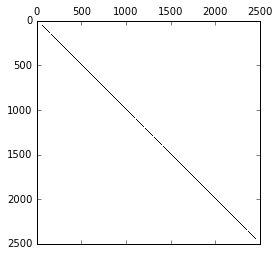

In [7]:
plt.spy(A)

In [8]:
U_old = numpy.zeros(M*N)
U_new = numpy.zeros(M*N)
# Initialize U vector
for i in range(N):
    U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)

In [9]:
for timestep in t:
    U_new = numpy.dot(A, U_old)+ rhs
    U_new[(N-1)*M: N*M] = (2*delta_s + 4.0*U_new[(N-2)*M: (N-1)*M]-U_new[(N-3)*M: (N-2)*M])/3.0
    for i in xrange(N):
        U_new[i*M]=(U_old[i*M]-r*i*delta_t*U_new[(i-1)*M] + kappa*theta*delta_t*U_new[i*M + 1]/delta_v)\
                   / ( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t)
    U_old = numpy.copy(U_new)

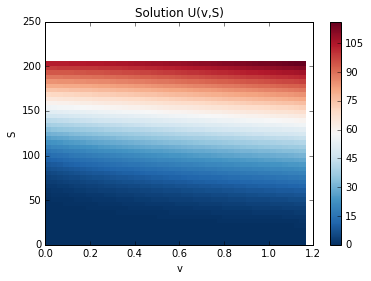

In [10]:
U_sol = numpy.reshape(U_new, [N, M])
E, X = numpy.meshgrid(v[:-5], s[:-7])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_sol[:-7,:-5], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)


In [11]:
print numpy.min(U_sol)
print U_sol.shape
print U_sol[-8,0], U_sol[-7,-5]
print rhs[-M-1:-1]

print s

0.0
(50, 50)
108.720854177 127.408285922
[ 235.1020408163265358    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                    0.                    0.
    0.                    0.                ]
[   0.                    4.897959183